# Data Exploration
Hi,

I've done some basic data exploration to get my bearings, and decided to release it publicly.

In this notebook, there are:

1. Basic checks of the columns, to understand what they are
2. Basic analysis of the annotations - plots of how detection frequency changes in each sequence
3. A visualiser for the data (you'll have to run the code yourself, as widgets don't work in the preview)

Feel free to use / copy / edit / do anything you like with the code :)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Image


# ROOT_DIR = Path("/kaggle/input/tensorflow-great-barrier-reef")
ROOT_DIR = Path("../data")

TRAIN_CSV = ROOT_DIR / "train.csv"
TRAIN_DF = pd.read_csv(TRAIN_CSV)

TEST_CSV = ROOT_DIR / "test.csv"
TEST_DF = pd.read_csv(TEST_CSV)

list(ROOT_DIR.iterdir())



# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for 
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in sorted(filenames):
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[PosixPath('../data/train.csv'), PosixPath('../data/test.csv')]

## Augment with commonly used things

In [3]:
# Count detections
if "detection_count" not in TRAIN_DF.columns:
    det_counts = TRAIN_DF.apply(lambda row: len(eval(row.annotations)), axis=1)
    TRAIN_DF["detection_count"] = det_counts

## What are the columns?

In [22]:
print(TRAIN_DF.info())
print()
print(TRAIN_DF.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23501 entries, 0 to 23500
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   video_id         23501 non-null  int64 
 1   sequence         23501 non-null  int64 
 2   video_frame      23501 non-null  int64 
 3   sequence_frame   23501 non-null  int64 
 4   image_id         23501 non-null  object
 5   annotations      23501 non-null  object
 6   detection_count  23501 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.3+ MB
None

   video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      

### What are the sequence IDs?


In [21]:
", ".join(map(str,
    sorted(list(TRAIN_DF["sequence"].unique()))
))

'996, 8399, 8503, 15827, 17665, 18048, 22643, 26651, 29424, 29859, 35305, 37114, 40258, 44160, 45015, 45518, 53708, 59337, 60510, 60754'

### Is the sequence_frame the same as video_frame

In [5]:
eq_frames = TRAIN_DF[TRAIN_DF["video_frame"] == TRAIN_DF["sequence_frame"]]
uneq_frames = TRAIN_DF[TRAIN_DF["video_frame"] != TRAIN_DF["sequence_frame"]]
print("eq frames, uneq frames:", eq_frames.size, uneq_frames.size)
print()
# No. Sequences start from 0, and they probably chopped the video where no starfish are seen

# So, videos are chopped into sequences, and each sequence goes from frame 0 to n

eq frames, uneq frames: 31129 133378



### Do sequence_frames go from 0 to N nicely?

In [6]:
print("Sequence frames sequential and start from 0?")
for seq_name in TRAIN_DF["sequence"].unique():
    sequential = True
    numbers = TRAIN_DF[TRAIN_DF["sequence"] == seq_name]["sequence_frame"].values
    numbers.sort()
    
    i = 0
    for num in numbers:
        while i < num:
            print(f"Seq {seq_name}: {Fore.RED}Missing {i}{Fore.RESET}")
            i += 1
        i += 1

    if sequential:
        print(f"Seq {seq_name}: {Fore.GREEN}Yes{Fore.RESET}")
print()
# Nice.  

Sequence frames sequential and start from 0?
Seq 40258: Yes
Seq 45518: Yes
Seq 59337: Yes
Seq 8399: Yes
Seq 45015: Yes
Seq 35305: Yes
Seq 53708: Yes
Seq 996: Yes
Seq 60510: Yes
Seq 44160: Yes
Seq 15827: Yes
Seq 29424: Yes
Seq 8503: Yes
Seq 18048: Yes
Seq 17665: Yes
Seq 60754: Yes
Seq 37114: Yes
Seq 26651: Yes
Seq 22643: Yes
Seq 29859: Yes



### Are video_frames sequential?

In [7]:
print("Video frames sequential?")
for seq_name in TRAIN_DF["sequence"].unique():
    sequential = True
    numbers = TRAIN_DF[TRAIN_DF["sequence"] == seq_name]["video_frame"].values
    numbers.sort()
    
    i = numbers[0]
    for num in numbers:
        while i < num:
            print(f"Seq {seq_name}: {Fore.RED}Missing {i}{Fore.RESET}")
            i += 1
        i += 1

    if sequential:
        print(f"Seq {seq_name}: {Fore.GREEN}Yes{Fore.RESET}")
print()
# Cool. Though I wonder if they'd give sequential data during evaluation.

# Are image id's just connected frame id's and video id's?
new_vid_ids = TRAIN_DF["video_id"].astype(str) + "-" + TRAIN_DF["video_frame"].astype(str)
print("How many images have strange image_ids:", (TRAIN_DF["image_id"] != new_vid_ids).sum())
# Great!

Video frames sequential?
Seq 40258: Yes
Seq 45518: Yes
Seq 59337: Yes
Seq 8399: Yes
Seq 45015: Yes
Seq 35305: Yes
Seq 53708: Yes
Seq 996: Yes
Seq 60510: Yes
Seq 44160: Yes
Seq 15827: Yes
Seq 29424: Yes
Seq 8503: Yes
Seq 18048: Yes
Seq 17665: Yes
Seq 60754: Yes
Seq 37114: Yes
Seq 26651: Yes
Seq 22643: Yes
Seq 29859: Yes

How many images have strange image_ids: 0


### Do videos have unique sequence names?

In [8]:
vid_seq_pairs = TRAIN_DF[["video_id", "sequence"]].drop_duplicates()
repeated_sequence_count = (vid_seq_pairs["sequence"].value_counts() != 1).sum()
print("How many repeated sequences:", repeated_sequence_count)
# eq_frames = TRAIN_DF[TRAIN_DF["video_frame"] == TRAIN_DF["sequence_frame"]]
# uneq_frames = TRAIN_DF[TRAIN_DF["video_frame"] != TRAIN_DF["sequence_frame"]]
# print("eq frames, uneq frames:", eq_frames.size, uneq_frames.size)
# print()

# Hmm, but maybe sequences are actually the sequence_ids of the first vid? Like, maybe the total ID is (sequence + sequence_frame)?
# No matter - sequences are unique and that's enough for analysis.

How many repeated sequences: 0


## How are the annotations distributed?

Starfish per image: 0     18582
1      2801
2       942
3       374
4       240
5       134
7        61
6        59
8        58
11       44
15       40
9        32
16       28
10       26
14       22
13       19
17       19
12       17
18        3
Name: detection_count, dtype: int64


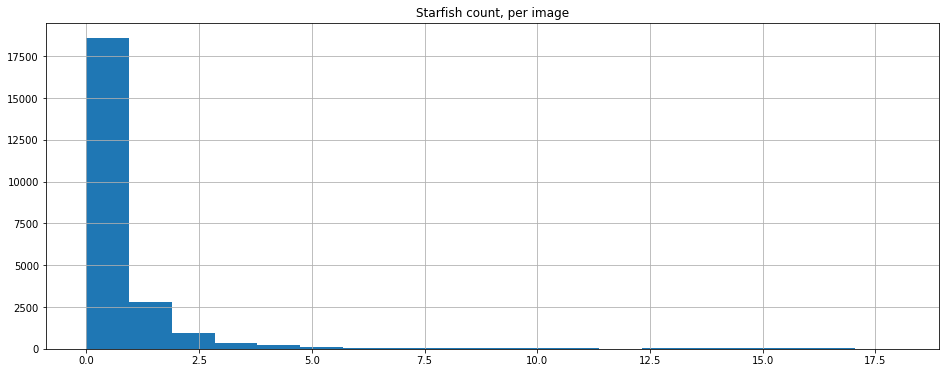

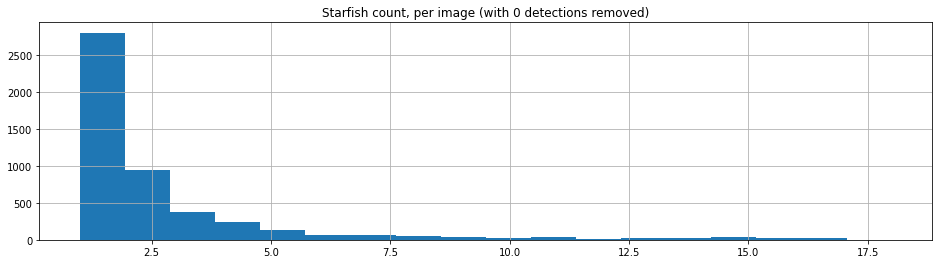

In [9]:
print(f"Starfish per image:", TRAIN_DF["detection_count"].value_counts())

bin_count = len(TRAIN_DF["detection_count"].unique())
plot = TRAIN_DF.hist(column="detection_count", figsize=(16,6), bins=bin_count)
ax = plot[0][0]
ax.set_title("Starfish count, per image")

TRAIN_DF_WITH_STARFISH = TRAIN_DF[TRAIN_DF["detection_count"] > 0]
bin_count = len(TRAIN_DF_WITH_STARFISH["detection_count"].unique())
plot = TRAIN_DF_WITH_STARFISH.hist(column="detection_count", figsize=(16,4), bins=bin_count)
ax = plot[0][0]
ax.set_title("Starfish count, per image (with 0 detections removed)");

## How do detections change during the frame?

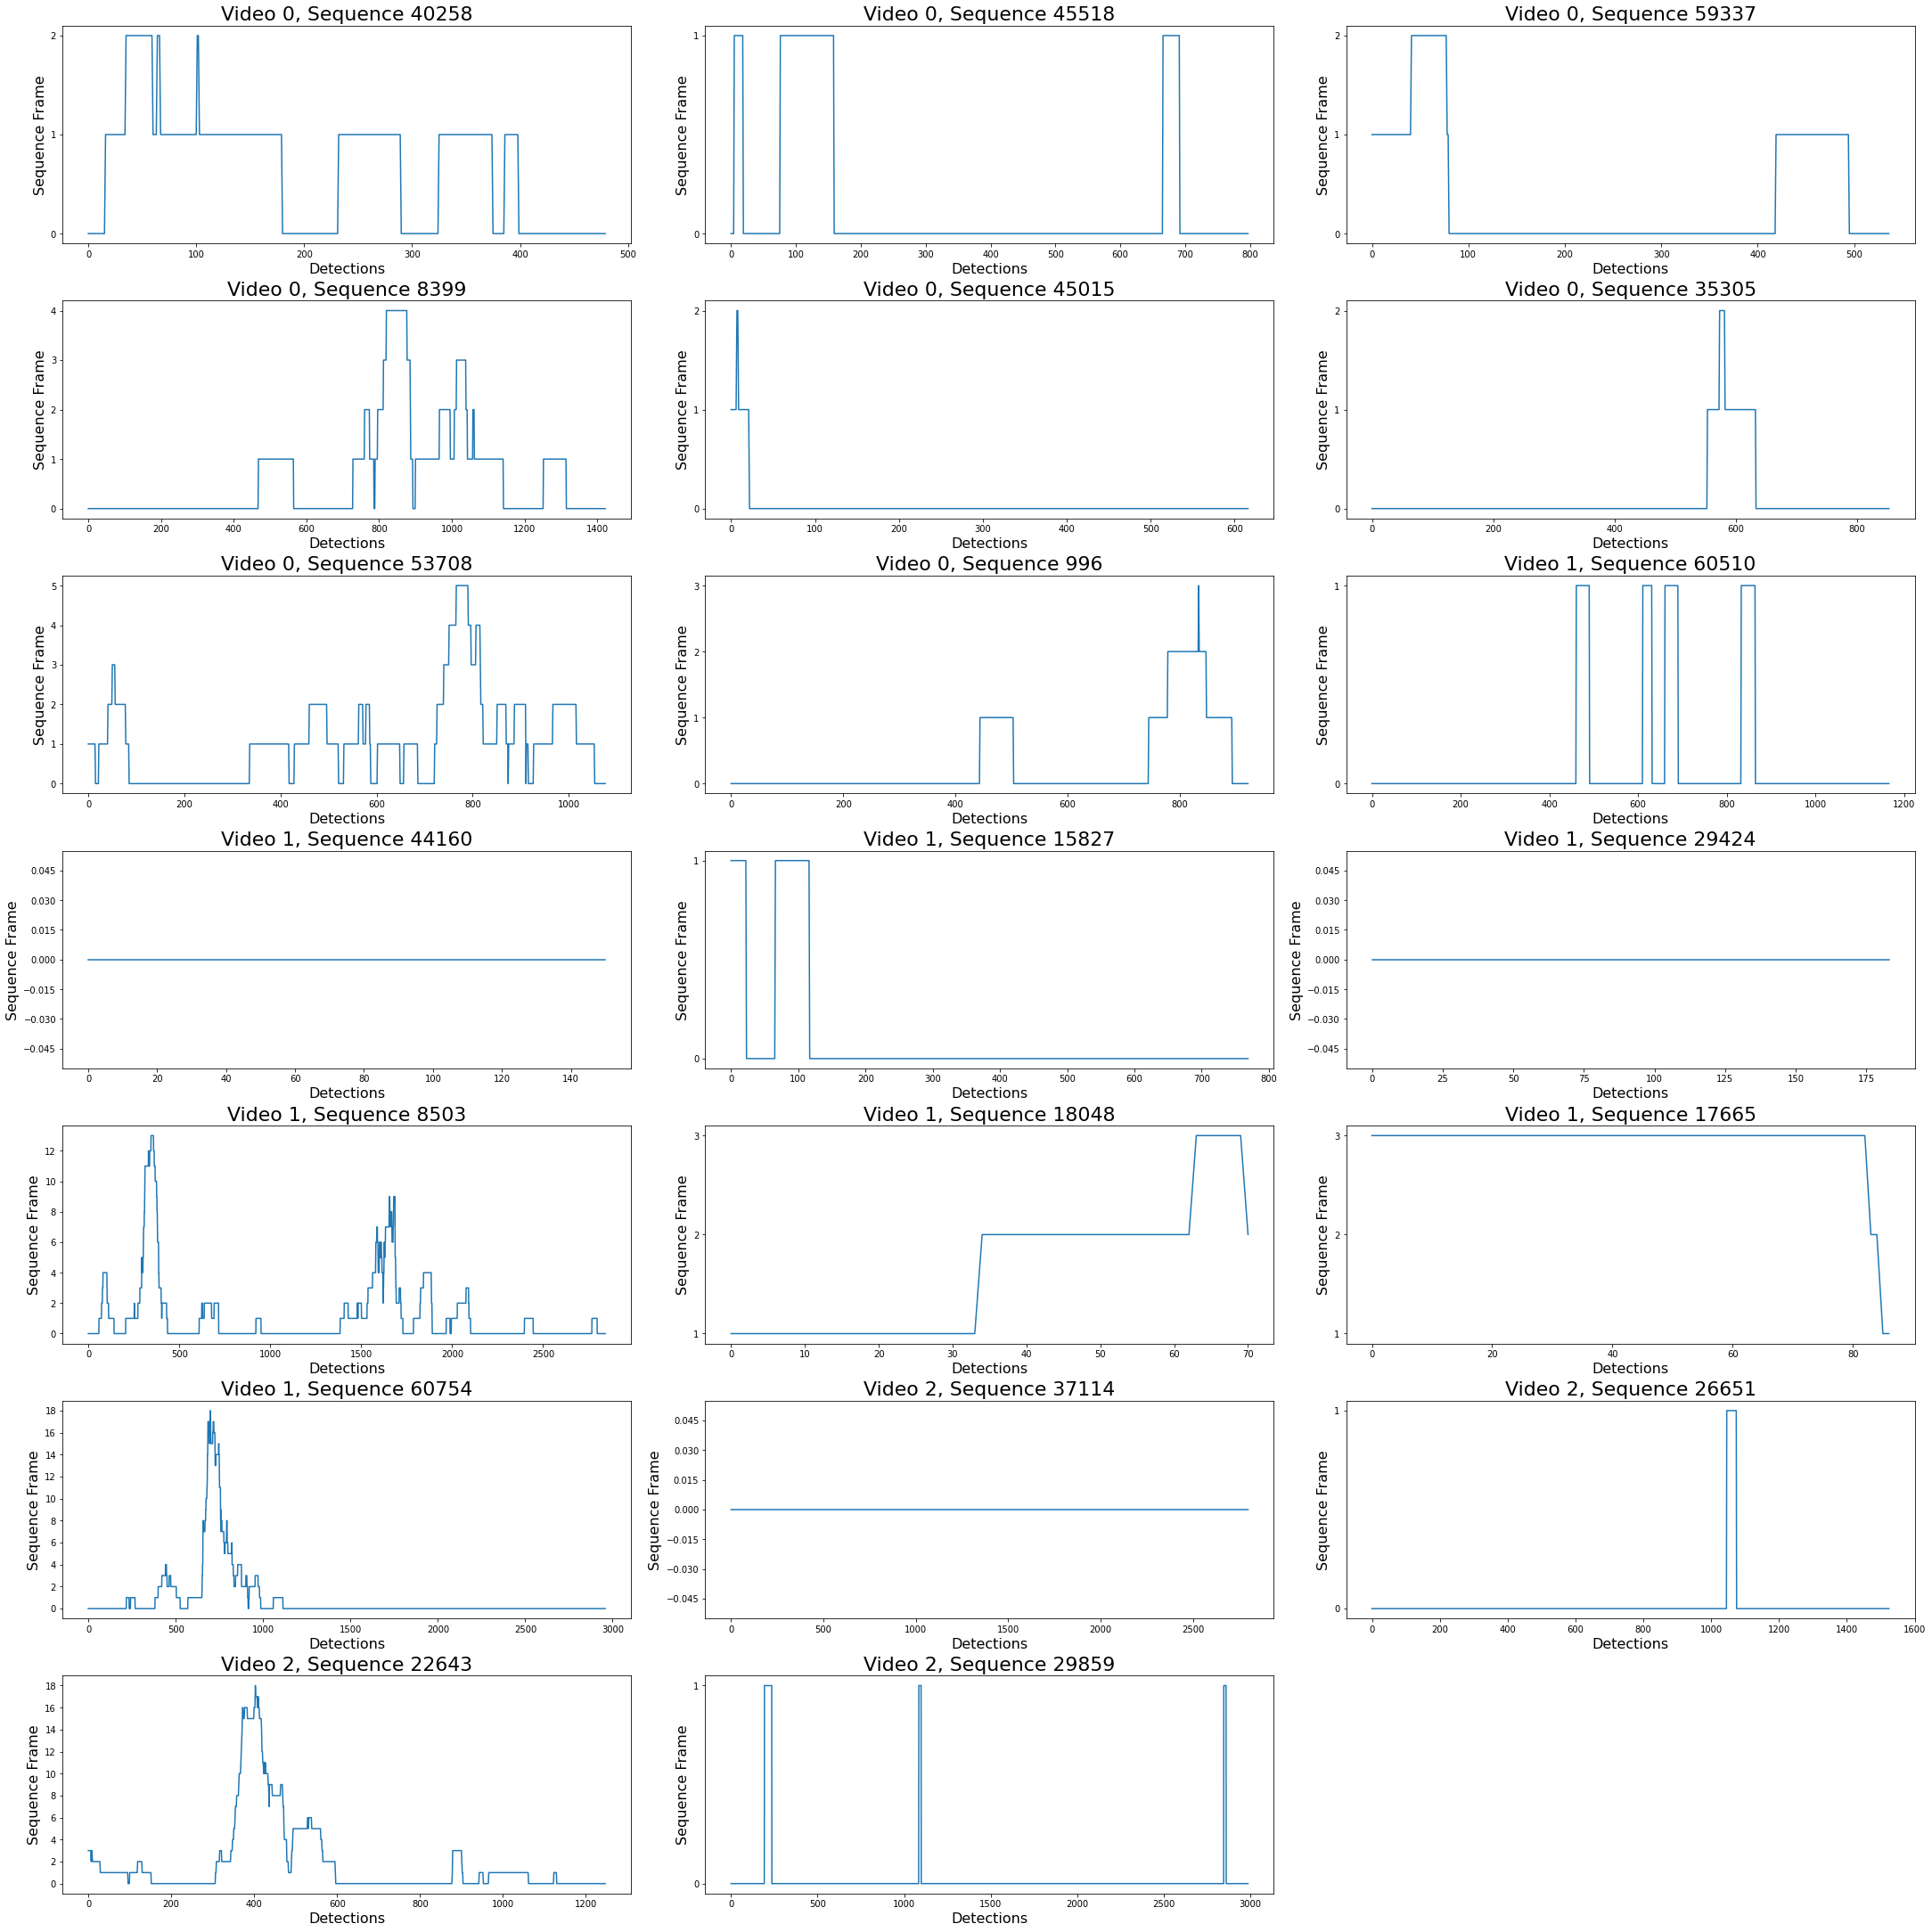

In [10]:
import math 


SEQUENCE_COUNT = len(TRAIN_DF["sequence"].drop_duplicates())
FIG_COLS = 3
FIG_ROWS = math.ceil(SEQUENCE_COUNT / FIG_COLS)
fig = plt.figure(figsize=(30, 30), constrained_layout=True)
# fig.tight_layout(pad=10.0)
# fig.tight_layout()

det_data = TRAIN_DF[["sequence", "video_id", "sequence_frame", "detection_count"]].drop_duplicates()
for i, seq_num in enumerate(det_data["sequence"].unique()):  # we know seq numbers are unique in train data
    # Get data
    seq_data = det_data[det_data["sequence"] == seq_num].sort_values(by="sequence_frame")
    seq_data = seq_data.set_index(seq_data["sequence_frame"]).drop(columns="sequence_frame")
    video_id = seq_data["video_id"].iloc[0]
    
    # Select figure position
    col = (i % FIG_COLS) + 1
    row = (i // FIG_COLS) + 1
    
    # Plot
    ax = plt.subplot(FIG_ROWS, FIG_COLS, i+1)
    ax = seq_data["detection_count"].plot.line(ax=ax)
    ax.set_title(f"Video {video_id}, Sequence {seq_num}", fontsize=22)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_xlabel('Detections', fontsize=16)
    ax.set_ylabel('Sequence Frame', fontsize=16)
    


# Visualise Annotations
> Note: the widgets don't work when previewing the notebook. If you want to use this, copy the notebook and then run it.

> Also, so you aren't surprised: it's not ideal. It takes 0.5s-1.5s to switch between images, as the notebook is not interactive and needs to clear each image before displaying a new one. More annoyingly, the outputs window clears everything and then displays it again, so the window pans up and down which is pretty annoying.

In [11]:
#  Cache / Selected values
video_ids = TRAIN_DF["video_id"].unique()
sel_video_id = 0
sel_video_df = TRAIN_DF[TRAIN_DF["video_id"] == sel_video_id]

sequences = sel_video_df["sequence"].unique()
sel_sequence = sequences[0]
sel_sequence_df = sel_video_df[sel_video_df["sequence"] == sel_sequence]

last_frame = sel_sequence_df["sequence_frame"].max()
sel_sequence_frame = 0
sel_sequence_frames = sel_sequence_df[sel_sequence_df["sequence_frame"] == sel_sequence_frame]
assert len(sel_sequence_frames) == 1
sel_video_frame = sel_sequence_frames["video_frame"].values[0]
sel_annotation = eval(sel_sequence_frames["annotations"].values[0])
  
# UI elements
dd_video_id = widgets.Dropdown(options=video_ids, description='Video ID:')
dd_sequence = widgets.Dropdown(options=sequences, description='Sequence:')
btn_first = widgets.Button(description="⏮️")
btn_back_50 = widgets.Button(description="⏪")
btn_back = widgets.Button(description="◀️")
btn_forward = widgets.Button(description="▶️")
btn_forward_50 = widgets.Button(description="⏩")
btn_last = widgets.Button(description="⏯")

out = widgets.Output()

dd_row = widgets.HBox([dd_video_id, dd_sequence])
btn_row = widgets.HBox([btn_first, btn_back_50, btn_back, btn_forward, btn_forward_50, btn_last])
all_widgets = widgets.VBox([dd_row, btn_row, out])

# Selection helpers (only change the data)
def set_frame(new_number):
    global sel_sequence_frame
    global sel_sequence_frames
    global sel_video_frame
    global sel_annotation
    
    sel_sequence_frame = max(0, min(new_number, last_frame))
    sel_sequence_frames = sel_sequence_df[sel_sequence_df["sequence_frame"] == sel_sequence_frame]
    assert len(sel_sequence_frames) == 1
    sel_video_frame = sel_sequence_frames["video_frame"].values[0]
    
    sel_annotation = eval(sel_sequence_frames["annotations"].values[0])

def set_sequence(new_number):
    global sel_sequence
    global sel_sequence_df
    global last_frame

    sel_sequence = new_number
    sel_sequence_df = sel_video_df[sel_video_df["sequence"] == sel_sequence]
    last_frame = sel_sequence_df["sequence_frame"].max()

    set_frame(0)
    
def set_video_id(new_id):
    global sel_video_id
    global sel_video_df
    global sequences
    
    sel_video_id = new_id
    sel_video_df = TRAIN_DF[TRAIN_DF["video_id"] == sel_video_id]

    sequences = sel_video_df["sequence"].unique()
    set_sequence(sequences[0])
    
# UI helpers (handle UI events + call selection helpers)
def clear_output():
    out.clear_output()
    
def draw_image():
    img_path = ROOT_DIR / "train_images" / f"video_{sel_video_id}" / f"{sel_video_frame}.jpg"
    assert img_path.is_file(), f"Cannot find image {img_path}"
    cv_img = cv2.imread(str(img_path))
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    draw_bboxes(cv_img, sel_annotation)

    with out:
        print("Image", img_path)

        # TODO: possible speedup - find a way to update images without clearing output
        img_fig = plt.figure(figsize=(20,16), facecolor="#123456ff", frameon=False)
        img_ax = img_fig.add_subplot(1, 1, 1)
        img_ax.get_xaxis().set_visible(False)
        img_ax.get_yaxis().set_visible(False)
        img_ax.use_sticky_edges = False
        # img_ax.margins(x=0)  # doesn't work. make img_fig.facecolor transparent instead as a hack.

        img_ax.imshow(cv_img)
        plt.show()

    
def draw_bboxes(cv_img, annotations):
    BBOX_COLOR_RGB = (255,126,0)
    for ann in annotations:
        cv2.rectangle(
            cv_img,
            (ann["x"] ,ann["y"]),
            (ann["x"] + ann["width"], ann["y"] + ann["height"]),
            color=BBOX_COLOR_RGB,
            thickness=3
        )

def on_click_forward(b):
    with out:
        set_frame(sel_sequence_frame + 1)
        clear_output()
        draw_image()
btn_forward.on_click(on_click_forward)
def on_click_back(b):
    with out:
        set_frame(sel_sequence_frame - 1)
        clear_output()
        draw_image()
btn_back.on_click(on_click_back)
def on_click_forward_50(b):
    with out:
        set_frame(sel_sequence_frame + 50)
        clear_output()
        draw_image()
btn_forward_50.on_click(on_click_forward_50)
def on_click_back_50(b):
    with out:
        set_frame(sel_sequence_frame - 50)
        clear_output()
        draw_image()
btn_back_50.on_click(on_click_back_50)
def on_click_first(b):
    with out:
        set_frame(0)
        clear_output()
        draw_image()
btn_first.on_click(on_click_first)
def on_click_last(b):
    with out:
        set_frame(last_frame)
        clear_output()
        draw_image()
btn_last.on_click(on_click_last)

def on_sequence_change(change):
    with out:
        if change["old"] == change["new"]:
            return
        set_sequence(change["new"])

        clear_output()
        draw_image()
dd_sequence.observe(on_sequence_change, names="value")

def on_video_id_change(change):
    with out:
        if change["old"] == change["new"]:
            return
        set_video_id(change["new"])
        dd_sequence.options = sequences
        
        clear_output()
        draw_image()
dd_video_id.observe(on_video_id_change, names="value")


display(all_widgets)
draw_image()

AssertionError: Cannot find image ../data/train_images/video_0/0.jpg